# Clouds simulations including PCA

In order to attempt to model the affect of clouds on our TOA GOME-2 reflectance signal we are going to use Principle Component Analysis (PCA) to separate the different contributions towards the signal into Principle Components (PC). This PCA needs to encompass all the spectral variance we would typically find in the area we are interested in. As the DASF model will be global we need to include all cloud types weighted according to their frequency of occurance. The different parameters we need to include in the Radiative Transfer (RT) model with which we will be simulating the cloud reflectance are: cloud liquid water content (lwc), ice/droplet effective radius, cloud top height, cloud bottom height, view and solar angles both azimuth and zenith, ice/water cloud type as well as typical atmospheric parameters that are important for our part of the spectrum we will be retrieving in. This includes: aerosol optical thickness (aot), atmosperic pressure at surface (press), atmospheric lwc. We will be assuming a completely absorbing lower boundary thus surface albedo of zero. 

## Cloud and atmospheric properties and their variances

In order to do the simulations a list of the parameters and their ranges need to be created. This list will be used to create the PCs. A list of cloud types and parameters are found in the Cloud_type_data.csv file. Ranges are based on either a 10% variance or a minimum and maximum value in the column with uniform distribution inbetween, or where distributions can be calculated based on global datasets such as AOT, wvc and pressure, a sample from this distribution will be selected. Depending on the amount of simulations chosen we will randomly sample from the distribution of points within the ranges and types. The global estimates of percentages of cloud types are kept fixed as taken from literature. The selected cloud spectra will be saved to a Dataframe in a hdf file which will be retrieved later for the PCA.

In [4]:
# do some preparation for all the cells below

import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
%matplotlib inline
import scipy as sc
import scipy.stats as stats
import pdb
from scipy import signal

fwhm = 0.4931 # fwhm of slit function nm
w_slit = 2 # width of slit function in nm

def slit_smooth(lam, spectrum, fwhm, width):
    '''
    Function that applies the gaussian slit function with known FWHM to spectrum.
    It will replace the boundaries of the smoothed spectrum which are affected by
    zero padding with the original spectrum.
    Input:
    lam - wavelenght array in nm
    spectrum - the spectrum to convolve
    fwhm - the full width half maximum of the gaussian in nm
    width - the width of the slit function in nm
    Output:
    convol - smoothed spectrum
    '''
    resol = np.average(np.diff(lam)) # average spectral resol of model in nm
    intervals = np.ceil((width / resol)+1) # the number of intervals in the width of slit
    slit = signal.gaussian(intervals, fwhm/2.3548201*intervals/width)
    convol = signal.fftconvolve(spectrum, slit/np.sum(slit), mode='same')
    hwidth = (intervals-1)/2
    convol[:intervals] = spectrum[:intervals]
    convol[-intervals-1:] = spectrum[-intervals-1:]
    return convol

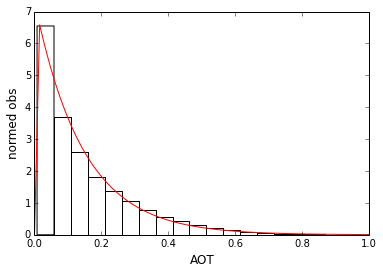

loc:7.66527e-03, scale:1.43909e-01


In [10]:
# prior to simulations get distributions of typical atmospheric parameters
# use the param variable to randomly select AOT simulations from an exponential distribution
# this distribution gives the best fit to the data.

# aerosols

import os
import glob
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import scipy.misc as misc
import gdal

root = '/home/malapradej/Documents/PhD_UCL/Data/SeaWIFS/Aerosols'
pattern = '*.h5'
crit = os.path.join(root, pattern)
Fns = glob.glob(crit)

crit_AOT = 'HDF5:\"%s\"://aerosol_optical_thickness_land'
crit_AOT_std = 'HDF5:\"%s\"://aerosol_optical_thickness_stddev_land'

Lat = []
Lon = []
AOT = []

for fn in Fns:
    dsn_aot = crit_AOT % fn
    ds_AOT = gdal.Open(dsn_aot)
    arr_AOT = ds_AOT.ReadAsArray()[2]
    arr_AOT = np.where(arr_AOT==-999, np.nan, arr_AOT)
    
    dsn_aot_std = crit_AOT_std % fn
    ds_AOT_std = gdal.Open(dsn_aot_std)
    arr_AOT_std = ds_AOT_std.ReadAsArray()[2]
    arr_AOT_std = np.where(arr_AOT_std==-999, np.nan, arr_AOT_std)
    
    arr_AOT = np.where(arr_AOT_std>0.3, np.nan, arr_AOT)
    AOT.append(arr_AOT)

AOT_flat = np.array(AOT).flatten()
AOT_flat = AOT_flat[~np.isnan(AOT_flat)]
weights = np.ones_like(AOT_flat)/len(AOT_flat)

y = AOT_flat
dist = stats.expon

x = np.linspace(0, y.max(), 100, endpoint=True)
# fit
param_aot = dist.fit(y) #shape, loc, scale
pdf_fitted = dist.pdf(x, *param_aot)
plt.plot(x, pdf_fitted, color='r')

# plot the histogram 
plt.hist(y, bins=30, color='w', normed=True)
plt.xlim(0,1)
plt.ylabel('normed obs', fontsize='large')
plt.xlabel('AOT', fontsize='large')
plt.show()
print 'loc:%.5e, scale:%.5e' %param_aot # loc:7.66527e-03, scale:1.43909e-01

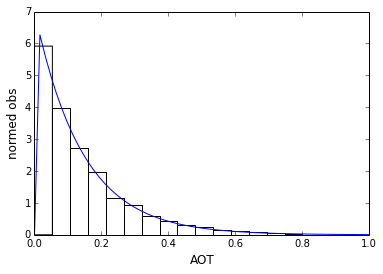

loc:2.53566e-05, scale:1.42384e-01


In [11]:
# now test to see if run of random exponential distribution with the params over many simulations get the same curve
test = []
for i in np.arange(4000):
    test.append(np.random.exponential(param_aot[-1]))

yt = np.array(test)
dist = stats.expon

xt = np.linspace(0, yt.max(), 100, endpoint=True)
# fit
paramt = dist.fit(yt) #shape, loc, scale
pdf_fittedt = dist.pdf(xt, *paramt)
plt.plot(xt, pdf_fittedt, color='b')

# plot the histogram 
plt.hist(yt, bins=30, color='w', normed=True)
plt.xlim(0,1)
plt.ylabel('normed obs', fontsize='large')
plt.xlabel('AOT', fontsize='large')
plt.show()
print 'loc:%.5e, scale:%.5e' %paramt # loc:4.28735e-05, scale:1.44300e-01

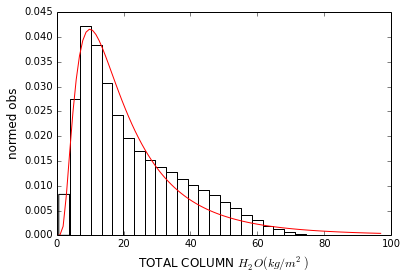

shape:7.63917e-01, loc:5.66790e-01, scale:1.68212e+01


In [12]:
# now for lwc or H2O total column from GOME-2 l2 product
# the files used are per orbit for June and Dec 2007. altogehter 7.9GB of data.
# the lognormal distribution gives the best fit to the lwc data.

import numpy as np
from fnmatch import fnmatch
%matplotlib inline
import h5py
import os

root = '/home/malapradej/Documents/PhD_UCL/Data/GOME-2/H2O/atmos.caf.dlr.de/gome2a/offline/2007'
pattern = '*.HDF5'
Fns = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            Fns.append(os.path.join(path, name))

TC_H2O = []
TC_H2O_err = []

nfiles = len(Fns)

for i, fn in enumerate(Fns):
    #print 'file %d or %d.' % (i, nfiles)
    f = h5py.File(fn, 'r')
    
    # select ordering of gasses
    gas = 'H2O'
    gas_nr = np.where(f[u'META_DATA'][u'MainSpecies'][:]==gas)[0][0]
    
    # total column
    # units of kg/m2 (libRadtran MM)
    # flag needs to be 0 for correct retrieval
    tc_H2O_flag = f[u'DETAILED_RESULTS'][u'QualityFlags'][:,gas_nr]  # column 5
    index_flag = np.where(tc_H2O_flag==0)[0]          # index of correct retrievals
    tc_H2O = f["/TOTAL_COLUMNS"][u'H2O'][:]
    index_fill = np.where(tc_H2O!=-1)[0]              # fill value of -1
    tc_H2O_err = f["/TOTAL_COLUMNS"][u'H2O_Error'][:]           # % error
    
    # view mode in binary
    # must be nadir (nominal) and descending part of orbit
    # which is 100000000 or 256
    view_mode = f[u'GEOLOCATION'][u'ViewMode'][:]
    index_nadir = np.where(view_mode==256)[0] # index of nadir pixels
    
    index_good = list(set(index_flag.flatten()) & set(index_nadir.flatten())\
            & set(index_fill.flatten()))
    
    tc_H2O = tc_H2O[index_good]
    tc_H2O_err = tc_H2O_err[index_good]
    
    TC_H2O.extend(list(tc_H2O))
    TC_H2O_err.extend(list(tc_H2O_err))
    
    f.close()

TC_H2O_flat = np.array(TC_H2O).flatten()
TC_H2O_err_flat = np.array(TC_H2O_err).flatten()
TC_H2O_flat = np.where(TC_H2O_err_flat>30, np.nan, TC_H2O)
TC_H2O_flat = TC_H2O_flat[~np.isnan(TC_H2O_flat)]

y = TC_H2O_flat
weights = np.ones_like(y)/len(y)
dist = stats.lognorm

x = np.linspace(0, y.max(), 100, endpoint=True)
# fit
param_wvc = dist.fit(y) #shape, loc, scale
pdf_fitted = dist.pdf(x, *param_wvc)
plt.plot(x, pdf_fitted, color='r')

# plot the histogram 
plt.hist(y, bins=30, normed=True, color='w')
plt.xlabel(r'TOTAL COLUMN $H_2O (kg/m^2)$', fontsize='large')
plt.ylabel('normed obs', fontsize='large')
plt.show()
print 'shape:%.5e, loc:%.5e, scale:%.5e' %param_wvc # shape:7.63917e-01, loc:5.66790e-01, scale:1.68212e+01

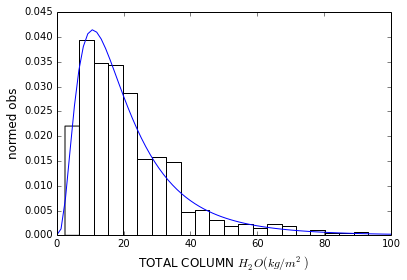

shape:6.76160e-01, loc:-5.78610e-01, scale:1.78925e+01


In [13]:
# test the lwc lognormal random number generator
test = []

for i in np.arange(600):
    test.append(stats.lognorm.rvs(s=param_wvc[0], loc=param_wvc[1], scale=param_wvc[2]))
    
yt = np.array(test)
dist = stats.lognorm

xt = np.linspace(0, yt.max(), 100, endpoint=True)
# fit
param_wvct = dist.fit(yt) #shape (std), loc (mean), scale
pdf_fittedt = dist.pdf(xt, *param_wvct)
plt.plot(xt, pdf_fittedt, color='b')

# plot the histogram 
plt.hist(yt, bins=30, normed=True, color='w')
plt.xlabel(r'TOTAL COLUMN $H_2O (kg/m^2)$', fontsize='large')
plt.ylabel('normed obs', fontsize='large')
plt.xlim(0,100)
plt.show()
print 'shape:%.5e, loc:%.5e, scale:%.5e' %param_wvct # shape:6.76160e-01, loc:-5.78610e-01, scale:1.78925e+01

In [6]:
# now for surface pressure
# the hyperbolic secant distribution gives the best fit to the pressure data
# THIS TAKES A TENS OF MINUTES TO COMPLETE....

import os
import glob
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import scipy.misc as misc
import gdal
import datetime
import subprocess

root = '/home/malapradej/Documents/PhD_UCL/Data/MIDAS/'
pattern = 'midas_glblwx*.txt'
crit = os.path.join(root, pattern)
Fns = glob.glob(crit)

col = [2, 4, 5, 26] # the columns for [src_id, ob_time, wmo_region_code, msl_pressure] at stations
coln = ['ob_time', 'src_id', 'wmo_region_code', 'msl_pressure']

PRESS = pd.DataFrame([])

# dateparsing function
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')

def file_len(fname):
        p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                                  stderr=subprocess.PIPE)
        result, err = p.communicate()
        if p.returncode != 0:
            raise IOError(err)
        return int(result.strip().split()[0])

chunksize = 100000 # no of lines per chunk

for fn in Fns:
    #print 'Reading file:%s' % fn
    lines = file_len(fn)/chunksize
    for i, chunk in enumerate(pd.read_csv(fn, usecols=col, header=None, delimiter='\s*,\s*', \
            parse_dates=[0], date_parser=dateparse, chunksize=chunksize)):
        #print 'chunk %d of %d' % (i+1, lines)
        # remove spaces before and after comma and convert col to date read 1000 rows at a time
        chunk.columns = coln
        chunk = chunk.dropna(subset=['ob_time', 'src_id', 'wmo_region_code', 'msl_pressure'], how='any')
        PRESS = PRESS.append(chunk)

Reading file:/home/malapradej/Documents/PhD_UCL/Data/MIDAS/midas_glblwx-south-west-pacific_200701-200712.txt
chunk 0 of 23
chunk 1 of 23
chunk 2 of 23
chunk 3 of 23
chunk 4 of 23
chunk 5 of 23
chunk 6 of 23
chunk 7 of 23
chunk 8 of 23
chunk 9 of 23
chunk 10 of 23
chunk 11 of 23
chunk 12 of 23
chunk 13 of 23
chunk 14 of 23
chunk 15 of 23
chunk 16 of 23
chunk 17 of 23
chunk 18 of 23
chunk 19 of 23
chunk 20 of 23
chunk 21 of 23
chunk 22 of 23
chunk 23 of 23
Reading file:/home/malapradej/Documents/PhD_UCL/Data/MIDAS/midas_glblwx-south-america_200701-200712.txt
chunk 0 of 5
chunk 1 of 5
chunk 2 of 5
chunk 3 of 5
chunk 4 of 5
chunk 5 of 5
Reading file:/home/malapradej/Documents/PhD_UCL/Data/MIDAS/midas_glblwx-antarctic_200701-200712.txt
chunk 0 of 1
chunk 1 of 1
Reading file:/home/malapradej/Documents/PhD_UCL/Data/MIDAS/midas_glblwx-europe_200701-200712.txt
chunk 0 of 48
chunk 1 of 48
chunk 2 of 48
chunk 3 of 48
chunk 4 of 48
chunk 5 of 48
chunk 6 of 48
chunk 7 of 48
chunk 8 of 48
chunk 9 of

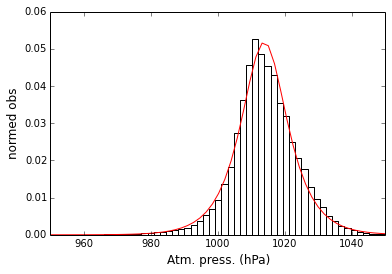

loc:1013.89770, scale:6.14236


In [445]:
# plot the histogram 

y = PRESS['msl_pressure'].values
dist = stats.hypsecant

x = np.linspace(y.min(), y.max(), 100, endpoint=True)
# fit
param_press = dist.fit(y, moments='k') #loc, scale
pdf_fitted = dist.pdf(x, *param_press)
plt.plot(x, pdf_fitted, color='r')

plt.hist(y, bins=100, color='w', normed=True)
plt.xlim(950,1050)
plt.ylabel('normed obs', fontsize='large')
plt.xlabel('Atm. press. (hPa)', fontsize='large')
plt.show()
print 'loc:%.5f, scale:%.5f' %param_press # loc:1013.89770, scale:6.14236

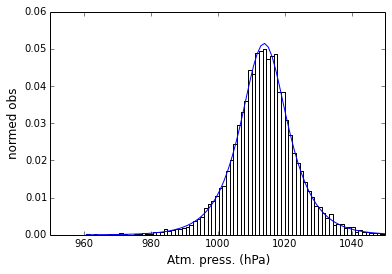

loc:1013.89770, scale:6.14236


In [8]:
# testing the random distribution selector

test = []

for i in np.arange(10000):
    test.append(stats.hypsecant.rvs(loc=param_press[0], scale=param_press[1]))
    
yt = np.array(test)

xt = np.linspace(yt.min(), yt.max(), 100, endpoint=True)
# fit
param_presst = dist.fit(yt) #shape, loc, scale
pdf_fittedt = dist.pdf(xt, *param_presst)
plt.plot(xt, pdf_fittedt, color='b')

# plot the histogram 
plt.hist(yt, bins=100, color='w', normed=True)
plt.xlim(950,1050)
plt.ylabel('normed obs', fontsize='large')
plt.xlabel('Atm. press. (hPa)', fontsize='large')
plt.show()
print 'loc:%.5f, scale:%.5f' %param_presst # loc:1013.89770, scale:6.14236

## Modelling of cloud reflectance based on distributions of cloud and atmospheric properties

Here we use the calculated distributions of atmospheric properties as well as distributions based on a literature review to model random cloud reflectances. This process takes more than 24 hours on one core for 2000 cloud simulations.

In [16]:
# list of cloud properties imported and simulations of cloud spectra.
# TAKES MORE THAN 24 HOURS TO COMPLETE....DON'T RUN UNLESS YOU HAVE NO DATA. FILES HAVE BEEN SAVED BASED ON PREVIOUS
# RUNS THAT CAN BE LOADED IN CELLS BELOW....

import subprocess
import re

# import the cloud type file and set up cloud type dataframe
cl_fn = 'Cloud_type_data.csv'
cl_df = pd.DataFrame.from_csv(cl_fn)

# set up a default profile file and amend the content during each iteration
# of the values in the dataframe
no_sims = 2000. # the number of simulations to do, will be spread out.
levels = 10 # the number of level intervals over which to spread the cloud
ran_var = 0.1 # variation allowed in parameters
tot_cld = np.float(cl_df.sum()['perc'])
# how many simulations per cloud type in sims column
cl_df['sims'] = np.round(cl_df['perc']/tot_cld*no_sims)

# atmospheric parameters need to be selected with ranges or distribution parameters
wvcp = param_wvc #np.array([0., 80])
aotp = param_aot #np.array([0.0, 1.0]) # aot needs to converted to transmittance before random selection
pressr = np.array([900., 1100]) #hPa
szar = np.array([0., 70.])
phi0r = np.array([0., 360.])
umur = np.array([1., 0.34202]) # 0 to 70 degrees
phir = np.array([0., 360.])
st_wl = 540.
en_wl = 800.

# libradtran input files
inp_default = 'data_files_path /usr/local/share/libRadtran/data/\n\
    output_quantity reflectivity \nmol_abs_param reptran\n\
    atmosphere_file tropics \nrte_solver disort \naerosol_default \
    \naerosol_species_file continental_average \
    \naerosol_set_tau_at_wvl 550 %.3f \nmol_modify H2O %.3f MM \
    \npressure %.3f \nsource solar /usr/local/share/libRadtran/data/solar_flux/atlas_plus_modtran\
    \nsza %.6f \nphi0 %.6f \numu %.6f \nphi %.6f \
    \nalbedo 0.0 \naltitude 0.0 \nzout TOA \nwavelength %.3f %.3f\
    \noutput_user lambda uu \n%s_file 1D \
    %s \ncloudcover %s 1'

# set an internal libRadtran wavelength grid file at 0.1nm interval to speed up computations
# but high enough to include all spectral features. we will smooth it later
wl_grid_fn = 'wl_grid.dat'
wl_int = 0.1
wl_grid = np.arange(st_wl, en_wl+wl_int, 0.1).T
np.savetxt(wl_grid_fn, wl_grid, fmt='%.2f')

temp_df = pd.DataFrame()
# the hierarchical index to use
col_abbr = [] # Abbreviation
col_cl_top = [] # Cloud top
col_lwc = []
col_rad = []
col_wvc = []
col_aot = []
col_press = []
col_sza = []
col_phi0 = []
col_umu = []
col_phi = []

ser_list = []

cl_prof_fn = 'cloud_temp.dat' # file name of profile file
for r in cl_df.iterrows(): # loop over cloud types
    print 'cloud type:%s' % r[1][0]
    
    cl_abbr = r[1].name
    
    cl_bot = r[1]['alt_bot']
    if isinstance(cl_bot, (float, int)):
        cl_bot = np.float(cl_bot)
    else:
        cl_bot = cl_bot.split('/')
        cl_bot = np.min(np.array(cl_bot).astype(np.float))
    
    cl_top_min = r[1]['alt_top_min']
    if isinstance(cl_top_min, (float, int)):
        cl_top_min = np.float(cl_top_min)
    else:
        cl_top_min = cl_top_min.split('/')
        cl_top_min = np.min(np.array(cl_top_min).astype(np.float))   
        
    cl_top_max = r[1]['alt_top_max']
    if isinstance(cl_top_max, (float, int)):
        cl_top_max = np.float(cl_top_max)
    else:
        cl_top_max = cl_top_max.split('/')
        cl_top_max = np.max(np.array(cl_top_max).astype(np.float))
        
    sims = r[1]['sims']
    wi = 'wc' if r[1]['iw'] == 'W' else 'ic'
    for s in np.arange(sims):
        lwc = r[1]['lwc']
        #pdb.set_trace()
        if isinstance(lwc, (float, int)):
            lwc = np.random.uniform(low=lwc-ran_var*lwc, high=lwc+ran_var*lwc)
        else:
            lwc = lwc.split('/')
            lwc_min = np.min(np.array(lwc).astype(np.float))
            lwc_max = np.max(np.array(lwc).astype(np.float))
            lwc = np.random.uniform(low=lwc_min-ran_var*lwc_min, high=lwc_max+ran_var*lwc_max)
            
        rad = r[1]['rad']
        if isinstance(rad, (float, int)):
            rad = np.random.uniform(low=rad-ran_var*rad, high=rad+ran_var*rad)
        else:
            rad = rad.split('/')
            rad_min = np.min(np.array(rad).astype(np.float))
            rad_max = np.max(np.array(rad).astype(np.float))
            rad = np.random.uniform(low=rad_min-ran_var*rad_min, high=rad_max+ran_var*rad_max)
        
        h = np.random.uniform(low=cl_top_min, high=cl_top_max)        
        hs = np.linspace(h, cl_bot, levels, endpoint=True) / 1000 # convert to km's
        
        lwca = np.repeat(lwc, levels)
        rada = np.repeat(rad, levels)
        cl_arr = np.array([hs, lwca, rada]).T
        np.savetxt(cl_prof_fn, cl_arr, delimiter=' ', fmt='%.5f')
        
        wvc = stats.lognorm.rvs(s=param_wvc[0], loc=param_wvc[1], scale=param_wvc[2])
        
        aot = np.random.exponential(aotp[-1])
        
        press = stats.hypsecant.rvs(loc=param_press[0], scale=param_press[1])
        
        sza_min = np.min(szar)
        sza_max = np.max(szar)
        sza = np.random.uniform(low=sza_min, high=sza_max)
        
        phi0_min = np.min(phi0r)
        phi0_max = np.max(phi0r)
        phi0 = np.random.uniform(low=phi0_min, high=phi0_max)
        
        umu_min = np.min(umur)
        umu_max = np.max(umur)
        umu = np.random.uniform(low=umu_min, high=umu_max)
        
        phi_min = np.min(phir)
        phi_max = np.max(phir)
        phi = np.random.uniform(low=phi_min, high=phi_max)
        
        inp_cloud = inp_default \
        %(aot, wvc, press, sza, phi0, umu, phi, st_wl, en_wl, wi, \
            cl_prof_fn, wi)
        process = subprocess.Popen('uvspec', stdin=subprocess.PIPE, stdout=\
            subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
        spectrum, err = process.communicate(input=inp_cloud)
        spectrum = re.split('[\n\s]+', spectrum)[1:-1]
        spectrum = np.array(map(float, spectrum))
        spectrum = np.reshape(spectrum, (-1,2))
        lam = spectrum[:,0]
        spectrum = spectrum[:,1]
        
        #smooth the spectrum using slit function
        spectrum = slit_smooth(lam, spectrum, fwhm, w_slit)
        
        spec_ser = pd.Series(data=spectrum, index=lam)
        ser_list.append(spec_ser)
        col_abbr.append(cl_abbr)
        col_lwc.append(lwc)
        col_rad.append(rad)
        col_cl_top.append(h)
        col_wvc.append(wvc)
        col_aot.append(aot)
        col_press.append(press)
        col_sza.append(sza)
        col_phi0.append(phi0)
        col_umu.append(umu)
        col_phi.append(phi)

# save to Dataframe and then hdf5 file on disk
spec_df = pd.DataFrame(data=ser_list).transpose()
mul_index = pd.MultiIndex.from_arrays([col_abbr, col_lwc, col_rad, col_cl_top, col_wvc,\
    col_aot, col_press, col_sza, col_phi0, col_umu, col_phi], names=['type', 'lwc', \
    'rad', 'cl_top', 'wvc', 'aot', 'press', 'sza', 'phi0', 'umu', 'phi'])
spec_df.columns = mul_index
spec_df.index.name = 'wavelength'
h5_fn = 'cloud_sims.h5'
if os.path.isfile(h5_fn):
    os.remove(h5_fn)
store = pd.HDFStore(h5_fn)
store['reflectance'] = spec_df
store.close()

cloud type:Fog
cloud type:Stratus
cloud type:Stratocumulus
cloud type:Cumulus
cloud type:Cumulonimbus
cloud type:Nimbostratus
cloud type:Altostratus
cloud type:Altocumulus
cloud type:Cirriform


In [2]:
# load the cloud reflectance data
# do this to skip the step above...

h5_fn = 'cloud_sims.h5'
spec_df = pd.read_hdf(h5_fn, key='reflectance')

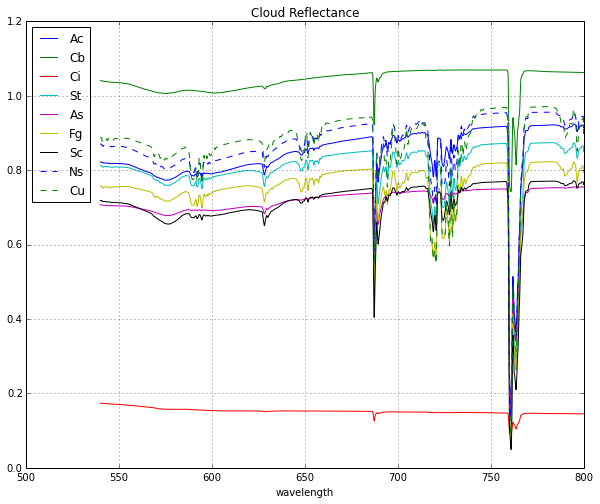

In [9]:
# plot reflectance from a sample of each cloud type
import random

styles = ['b-','g-','r-', 'c-', 'm-', 'y-', 'k-', 'b--', 'g--']
columns = spec_df.columns
seen = dict()
for col in columns:
    seen.setdefault(col[0], []).append(col) # dictionary with keys as type (eg. 'Fg') and col index values
        # appended as tuples
cols = [random.choice(seen[firstcol]) for firstcol in seen] # loop over keys and random select a tuple
spec_df[cols].plot(title='Cloud Reflectance', figsize=(10,8), style=styles, legend=False)
labels = [i[0] for i in cols]
plt.legend(labels, loc='best')

## Principle Componant Analysis (PCA) of all clouds

All the cloud simulations were saved in an hdf file which will be loaded again to do the PCA. PCs are calculated, saved into hdf file and plotted. Two separate PCAs will be done. The first over the red-edge known as simply as 'pca_red_edge' and the second pca over the 600 nm to 800 nm range for future SIF retrievals known as 'pca_sif_range'. There is a 'pca' dataset on the hdf file but this SHOULD NOT BE USED!!!!!

In [10]:
# load the cloud reflectance data

h5_fn = 'cloud_sims.h5'
spec_df = pd.read_hdf(h5_fn, key='reflectance')

In [484]:
# PCA over red-edge.
# Do the PCA and store in Dataframe

from sklearn.decomposition import PCA

# select the wavelengths range over the red-edge
min_wl = 680
max_wl = 755

# select the number of PC to calculate
n_comp = 10

spec_sub_df = spec_df[np.logical_and(spec_df.index>=min_wl, spec_df.index<=max_wl)]

# fit the PCA to the cloud data
specs_sub_df = np.array(spec_sub_df).T
pca = PCA(n_components=n_comp)
pca.fit(specs_sub_df)

# save the pca into a dataframe and onto disk file
pc_cols1 = ['PC'+str(i).zfill(2) for i in range(1, n_comp+1)]
pc_cols2 = [i for i in pca.explained_variance_ratio_]
pca_df = pd.DataFrame(pca.components_.T, index=spec_sub_df.index, columns=[pc_cols1, \
    pc_cols2])
pca_df.index.name = spec_sub_df.index.name
pca_df.columns.names = ['PCs', 'explained_variance_ratio']

In [478]:
# store the red-edge pca Dataframe into hdf file and close it
h5_fn = 'cloud_sims.h5'
store = pd.HDFStore(h5_fn)
store['pca_red_edge'] = pca_df
store.close()

In [481]:
# store the red-edge PCA object in a pickled file for later retrieval and re-analysis
from sklearn.externals import joblib
# save the pca object to a pickle file
pkl_fn = 'pca_red_edge.p'
joblib.dump(pca, pkl_fn)

['pca_red_edge.p',
 'pca_red_edge.p_01.npy',
 'pca_red_edge.p_02.npy',
 'pca_red_edge.p_03.npy',
 'pca_red_edge.p_04.npy']

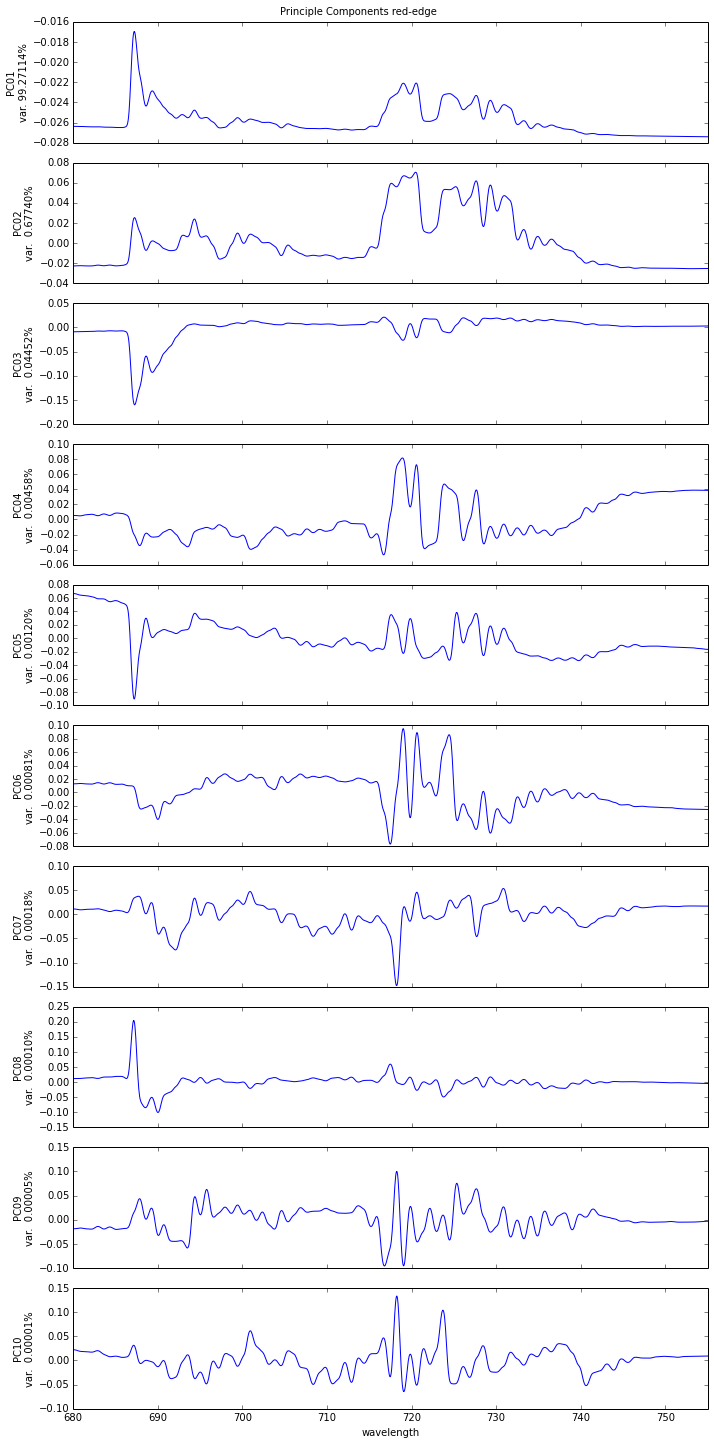

In [479]:
# plot the PC's over the red-edge
# PC's could be negative if the cloud reflectances reduce in reflectance from
# 1st to last, and vice versa for positives.

# load pca dataframe
h5_fn = 'cloud_sims.h5'
pca_df = pd.read_hdf(h5_fn, key='pca_red_edge')

n_pcs = len(pca_df.columns)

fig, axes = plt.subplots(nrows=n_pcs, ncols=1, sharex=True)
fig.set_figheight(2*n_pcs)
fig.set_figwidth(10)
plt.suptitle('Principle Components red-edge', y=1)
for i, (pc_var, ax) in enumerate(zip(pca_df, axes)):
    ax.plot(pca_df.index, pca_df.icol(i).values)
    ax.set_ylabel('%s\nvar. %8.5f%%' %(pc_var[0], pc_var[1]*100))
    ax.set_xlim(min(pca_df.index), max(pca_df.index))
plt.xlabel(pca_df.index.names[0])
plt.tight_layout()

Note that the following about PCs:
* PC01: Strong influence of __O2B absorption bands__. O2 is well mixed throughout the atmosphere and the column values are mostly regulated by surface pressure changes. Some H2O absorption feature influence is present although not as much as O2. O2 is still abundant above the troposphere whereas H2O vapour is mostly found in the lower troposphere. Thus PC01 contains mostly __surface pressure__ and __cloud top altitudes__ effects, especialy for the higher clouds above the zone of high atmospheric water vapour levels. 
* PC02: __H2O vapour absorption__ features and some O2B. __Low and mid altitude cloud__ influence where H2O absorption would play a larger role in the variance. Height difference at lower troposphere and relative WVC plays role here.
* PC03: As __O2B is varying__ and __H2O__ is almost __stationary__, points to a small influence of cloud top heights, and mostly influence of solar and view __zenith angle variations__ through the atmosphere. This is the case where a cloud top is fixed above zone of high water vapour and only influence to variance could be from a longer pathlength through the atmosphere with abundant O2, which points to anglular variations which affect the path length.
* PC04: The __slope of the reflectance spectrum__ starts to appear. Influence of __ice or water__ particles. Ice clouds such as cirrus has a reduction in reflectance towards longer wavelengths in our range, whereas the water clouds increase in reflectance with wavelength. 
* PC05. Even more influence of __slope__ thus __ice or water__ cloud separation. 
Although there may be some explanation to the remaining PCs this is not currently clear. We can also assume that the higher PCs will contain mostly the influence of inaccuracies in the model formulation. 

A separate PCA was done over the 600 to 800 nm range over which SIF occurs. This may be usefull for modelling the influence of clouds on the SIF retrievals, and thus correcting for it.

In [482]:
# PCA over SIF spectrum. 600 to 800 nm.
# Do the PCA and store in Dataframe

from sklearn.decomposition import PCA

# select the wavelengths range over the red-edge
min_wl = 600
max_wl = 800

# select the number of PC to calculate
n_comp = 10

spec_sub_df = spec_df[np.logical_and(spec_df.index>=min_wl, spec_df.index<=max_wl)]

# fit the PCA to the cloud data
specs_sub_df = np.array(spec_sub_df).T
pca = PCA(n_components=n_comp)
pca.fit(specs_sub_df)

# save the pca into a dataframe and onto disk file
pc_cols1 = ['PC'+str(i).zfill(2) for i in range(1, n_comp+1)]
pc_cols2 = [i for i in pca.explained_variance_ratio_]
pca_df = pd.DataFrame(pca.components_.T, index=spec_sub_df.index, columns=[pc_cols1, \
    pc_cols2])
pca_df.index.name = spec_sub_df.index.name
pca_df.columns.names = ['PCs', 'explained_variance_ratio']

In [459]:
# store the SIF pca Dataframe into hdf file and close it
h5_fn = 'cloud_sims.h5'
store = pd.HDFStore(h5_fn)
store['pca_sif_range'] = pca_df
store.close()

In [483]:
# store the SIF PCA object in a pickled file for later retrieval and re-analysis
from sklearn.externals import joblib
# save the pca object to a pickle file
pkl_fn = 'pca_sif_range.p'
joblib.dump(pca, pkl_fn)

['pca_sif_range.p',
 'pca_sif_range.p_01.npy',
 'pca_sif_range.p_02.npy',
 'pca_sif_range.p_03.npy',
 'pca_sif_range.p_04.npy']

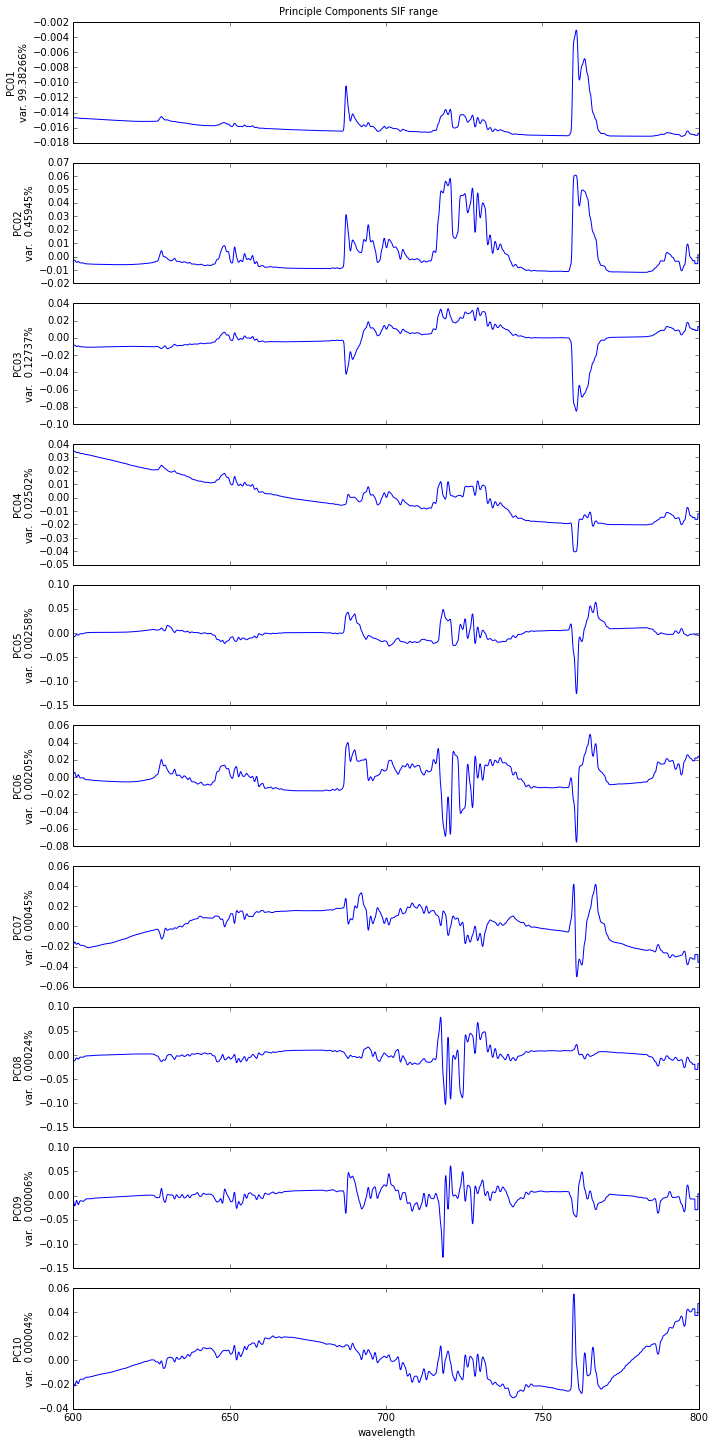

In [460]:
# plot the PC's for SIF range
# PC's could be negative if the cloud reflectances reduce in reflectance from
# 1st to last, and vice versa for positives.

# load pca dataframe
h5_fn = 'cloud_sims.h5'
pca_df = pd.read_hdf(h5_fn, key='pca_sif_range')

n_pcs = len(pca_df.columns)

fig, axes = plt.subplots(nrows=n_pcs, ncols=1, sharex=True)
fig.set_figheight(2*n_pcs)
fig.set_figwidth(10)
plt.suptitle('Principle Components SIF range', y=1)
for i, (pc_var, ax) in enumerate(zip(pca_df, axes)):
    ax.plot(pca_df.index, pca_df.icol(i).values)
    ax.set_ylabel('%s\nvar. %8.5f%%' %(pc_var[0], pc_var[1]*100))
    ax.set_xlim(min(pca_df.index), max(pca_df.index))
plt.xlabel(pca_df.index.names[0])
plt.tight_layout()

## Additional simulations to explain the effects of parameters on the PCs

Although not yet attempted additional model runs can be done which will help to explain the influence of different parameters on PCs. Here we can think of running simulations with varying cloud top height with other parameters kept at their mean global values. 
* The plot of reflectance curves inside the O2B and H2O absorption bands and outside the bands in locations of low absorption vs height could help to explain the role canopy height plays in PCs. Explaining PC01.
* A similar plot of reflectance inside absorption bands and outside at high and low altitude vs wvc would show the influence of water vapour on absorption bands at different altitudes. Explaining PC02.
* Plots of reflectance inside and outside absorption bands at a constant but high altitude vs varying phase angle beween sun and sensor. Explaining PC03. 
* Plots of reflectance at two points outside absorption bands at the extremes of the spectrum vs various fractions of ice or water clouds in a fully cloud covered pixel. Also could envisage a slope between the two points vs fraction of ice or water cloud types. Explaining PC04 and PC05.

## Testing the PCA model using a separate cloud simulation dataset

In order to test the cloud PCA we need to create a separate testing cloud spectrum dataset. The same random sampling distribution is used to create an independent cloud spectra dataset. This was done as the distributions are based on actual measurements done globally and should reflect all possible ranges of parameters encountered. The test dataset will be saved in a separate hdf file. Optimization will be achieved between the different cloud spectra as independent variable and the PCs as dependent variable. The forward model using the coefficients of PCs will be compared against the test simulated spectrum. Differences will be termed residuals which will then be used to calculate a RMSE of the PCA model. The optimization will be run using increasing numbers of PCs to show the effect of increasing the number of PCs to the result. The model used for optimization will be:

$$
\rho_{cld_\lambda} = c_1 PC_{1_\lambda} + c_2 PC_{2_\lambda} + ... + c_n PC_{n_\lambda} + \epsilon_{\lambda}
$$

This can be solved linearly using Ordinary least squares (OLS). Where $\rho_{cld_\lambda}$ is the simulated cloud reflectance value at wavelenght $\lambda$ and $c_1$ to $c_n$ the coefficients of the PCs in $PC_{1_\lambda}$ to $PC_{n_\lambda}$. $\epsilon_{\lambda}$ is the residual per wavelength. 

In [485]:
# list of cloud properties imported and simulations of cloud spectra.
# TAKES MORE THAN <...> HOURS TO COMPLETE....DON'T RUN UNLESS YOU HAVE NO DATA. FILES HAVE BEEN SAVED BASED ON PREVIOUS
# RUNS THAT CAN BE LOADED IN CELLS BELOW....

import subprocess
import re

# import the cloud type file and set up cloud type dataframe
cl_fn = 'Cloud_type_data.csv'
cl_df = pd.DataFrame.from_csv(cl_fn)

# set up a default profile file and amend the content during each iteration
# of the values in the dataframe
no_sims = 200. # the number of simulations to do, will be spread out.
levels = 10 # the number of level intervals over which to spread the cloud
ran_var = 0.1 # variation allowed in parameters
tot_cld = np.float(cl_df.sum()['perc'])
# how many simulations per cloud type in sims column
cl_df['sims'] = np.round(cl_df['perc']/tot_cld*no_sims)

# atmospheric parameters need to be selected with ranges or distribution parameters
wvcp = param_wvc #np.array([0., 80])
aotp = param_aot #np.array([0.0, 1.0]) # aot needs to converted to transmittance before random selection
pressr = np.array([900., 1100]) #hPa
szar = np.array([0., 70.])
phi0r = np.array([0., 360.])
umur = np.array([1., 0.34202]) # 0 to 70 degrees
phir = np.array([0., 360.])
st_wl = 540.
en_wl = 800.

# libradtran input files
inp_default = 'data_files_path /usr/local/share/libRadtran/data/\n\
    output_quantity reflectivity \nmol_abs_param reptran\n\
    atmosphere_file tropics \nrte_solver disort \naerosol_default \
    \naerosol_species_file continental_average \
    \naerosol_set_tau_at_wvl 550 %.3f \nmol_modify H2O %.3f MM \
    \npressure %.3f \nsource solar /usr/local/share/libRadtran/data/solar_flux/atlas_plus_modtran\
    \nsza %.6f \nphi0 %.6f \numu %.6f \nphi %.6f \
    \nalbedo 0.0 \naltitude 0.0 \nzout TOA \nwavelength %.3f %.3f\
    \noutput_user lambda uu \n%s_file 1D \
    %s \ncloudcover %s 1'

# set an internal libRadtran wavelength grid file at 0.1nm interval to speed up computations
# but high enough to include all spectral features. we will smooth it later
wl_grid_fn = 'wl_grid.dat'
wl_int = 0.1
wl_grid = np.arange(st_wl, en_wl+wl_int, 0.1).T
np.savetxt(wl_grid_fn, wl_grid, fmt='%.2f')

temp_df = pd.DataFrame()
# the hierarchical index to use
col_abbr = [] # Abbreviation
col_cl_top = [] # Cloud top
col_lwc = []
col_rad = []
col_wvc = []
col_aot = []
col_press = []
col_sza = []
col_phi0 = []
col_umu = []
col_phi = []

ser_list = []

cl_prof_fn = 'cloud_temp.dat' # file name of profile file
for r in cl_df.iterrows(): # loop over cloud types
    print 'cloud type:%s' % r[1][0]
    
    cl_abbr = r[1].name
    
    cl_bot = r[1]['alt_bot']
    if isinstance(cl_bot, (float, int)):
        cl_bot = np.float(cl_bot)
    else:
        cl_bot = cl_bot.split('/')
        cl_bot = np.min(np.array(cl_bot).astype(np.float))
    
    cl_top_min = r[1]['alt_top_min']
    if isinstance(cl_top_min, (float, int)):
        cl_top_min = np.float(cl_top_min)
    else:
        cl_top_min = cl_top_min.split('/')
        cl_top_min = np.min(np.array(cl_top_min).astype(np.float))   
        
    cl_top_max = r[1]['alt_top_max']
    if isinstance(cl_top_max, (float, int)):
        cl_top_max = np.float(cl_top_max)
    else:
        cl_top_max = cl_top_max.split('/')
        cl_top_max = np.max(np.array(cl_top_max).astype(np.float))
        
    sims = r[1]['sims']
    wi = 'wc' if r[1]['iw'] == 'W' else 'ic'
    for s in np.arange(sims):
        lwc = r[1]['lwc']
        if isinstance(lwc, (float, int)):
            lwc = np.random.uniform(low=lwc-ran_var*lwc, high=lwc+ran_var*lwc)
        else:
            lwc = lwc.split('/')
            lwc_min = np.min(np.array(lwc).astype(np.float))
            lwc_max = np.max(np.array(lwc).astype(np.float))
            lwc = np.random.uniform(low=lwc_min-ran_var*lwc_min, high=lwc_max+ran_var*lwc_max)
            
        rad = r[1]['rad']
        if isinstance(rad, (float, int)):
            rad = np.random.uniform(low=rad-ran_var*rad, high=rad+ran_var*rad)
        else:
            rad = rad.split('/')
            rad_min = np.min(np.array(rad).astype(np.float))
            rad_max = np.max(np.array(rad).astype(np.float))
            rad = np.random.uniform(low=rad_min-ran_var*rad_min, high=rad_max+ran_var*rad_max)
        
        h = np.random.uniform(low=cl_top_min, high=cl_top_max)        
        hs = np.linspace(h, cl_bot, levels, endpoint=True) / 1000 # convert to km's
        
        lwca = np.repeat(lwc, levels)
        rada = np.repeat(rad, levels)
        cl_arr = np.array([hs, lwca, rada]).T
        np.savetxt(cl_prof_fn, cl_arr, delimiter=' ', fmt='%.5f')
        
        wvc = stats.lognorm.rvs(s=param_wvc[0], loc=param_wvc[1], scale=param_wvc[2])
        
        aot = np.random.exponential(aotp[-1])
        
        press = stats.hypsecant.rvs(loc=param_press[0], scale=param_press[1])
        
        sza_min = np.min(szar)
        sza_max = np.max(szar)
        sza = np.random.uniform(low=sza_min, high=sza_max)
        
        phi0_min = np.min(phi0r)
        phi0_max = np.max(phi0r)
        phi0 = np.random.uniform(low=phi0_min, high=phi0_max)
        
        umu_min = np.min(umur)
        umu_max = np.max(umur)
        umu = np.random.uniform(low=umu_min, high=umu_max)
        
        phi_min = np.min(phir)
        phi_max = np.max(phir)
        phi = np.random.uniform(low=phi_min, high=phi_max)
        
        inp_cloud = inp_default \
        %(aot, wvc, press, sza, phi0, umu, phi, st_wl, en_wl, wi, \
            cl_prof_fn, wi)
        process = subprocess.Popen('uvspec', stdin=subprocess.PIPE, stdout=\
            subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
        spectrum, err = process.communicate(input=inp_cloud)
        spectrum = re.split('[\n\s]+', spectrum)[1:-1]
        spectrum = np.array(map(float, spectrum))
        spectrum = np.reshape(spectrum, (-1,2))
        lam = spectrum[:,0]
        spectrum = spectrum[:,1]
        
        #smooth the spectrum using slit function
        spectrum = slit_smooth(lam, spectrum, fwhm, w_slit)
        
        spec_ser = pd.Series(data=spectrum, index=lam)
        ser_list.append(spec_ser)
        col_abbr.append(cl_abbr)
        col_lwc.append(lwc)
        col_rad.append(rad)
        col_cl_top.append(h)
        col_wvc.append(wvc)
        col_aot.append(aot)
        col_press.append(press)
        col_sza.append(sza)
        col_phi0.append(phi0)
        col_umu.append(umu)
        col_phi.append(phi)

# save to Dataframe and then hdf5 file on disk
spec_test_df = pd.DataFrame(data=ser_list).transpose()
mul_index = pd.MultiIndex.from_arrays([col_abbr, col_lwc, col_rad, col_cl_top, col_wvc,\
    col_aot, col_press, col_sza, col_phi0, col_umu, col_phi], names=['type', 'lwc', \
    'rad', 'cl_top', 'wvc', 'aot', 'press', 'sza', 'phi0', 'umu', 'phi'])
spec_test_df.columns = mul_index
spec_test_df.index.name = 'wavelength'
h5_fn = 'cloud_sims_test.h5'
if os.path.isfile(h5_fn):
    os.remove(h5_fn)
store = pd.HDFStore(h5_fn)
store['reflectance'] = spec_test_df
store.close()

cloud type:Fog
cloud type:Stratus
cloud type:Stratocumulus
cloud type:Cumulus
cloud type:Cumulonimbus
cloud type:Nimbostratus
cloud type:Altostratus
cloud type:Altocumulus
cloud type:Cirriform


In [11]:
# load the test cloud reflectance data
# do this to skip the step above...

h5_fn = 'cloud_sims_test.h5'
spec_test_df = pd.read_hdf(h5_fn, key='reflectance')

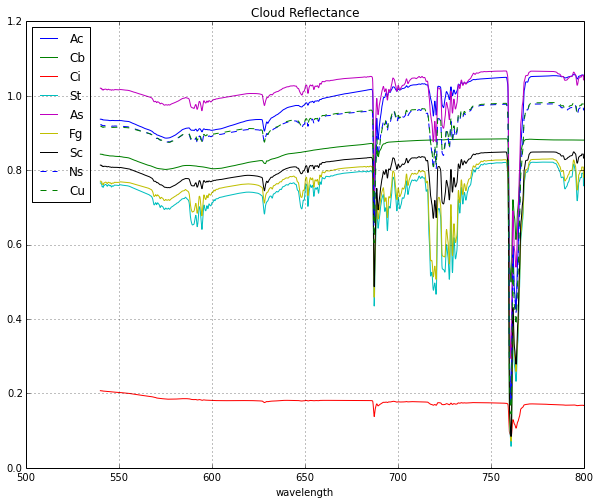

In [12]:
# plot test data reflectance from a sample of each cloud type
import random

styles = ['b-','g-','r-', 'c-', 'm-', 'y-', 'k-', 'b--', 'g--']
columns = spec_test_df.columns
seen = dict()
for col in columns:
    seen.setdefault(col[0], []).append(col) # dictionary with keys as type (eg. 'Fg') and col index values
        # appended as tuples
cols = [random.choice(seen[firstcol]) for firstcol in seen] # loop over keys and random select a tuple
spec_test_df[cols].plot(title='Cloud Reflectance', figsize=(10,8), style=styles, legend=False)
labels = [i[0] for i in cols]
plt.legend(labels, loc='best')

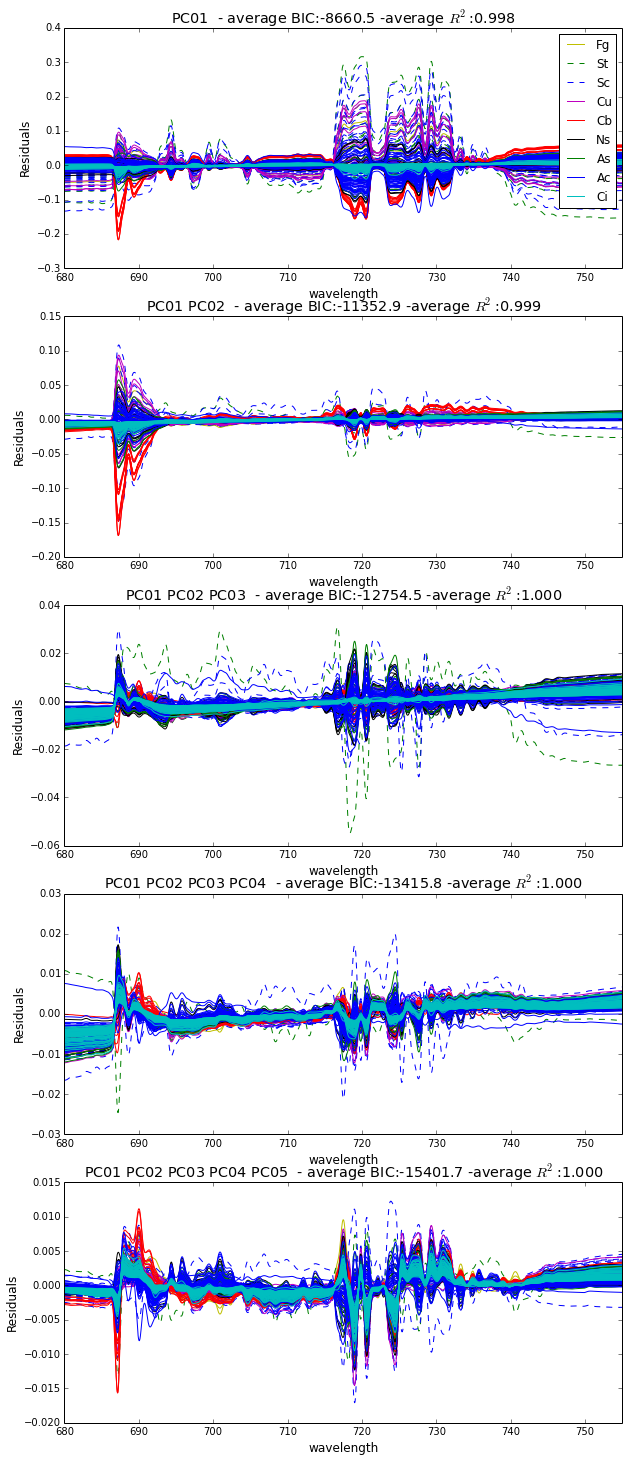

In [658]:
# minimize cloud reflectance over all the test spectra and save results of parameters per test spectra for
# every increasing PC model

import statsmodels.formula.api as sm

# load pca
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

min_wl = pca_red_df.index[0]
max_wl = pca_red_df.index[-1]

# get test spectrum to same wavelength range as pca
spec_test_df = spec_test_df[np.logical_and(spec_test_df.index>=min_wl, spec_test_df.index<=max_wl)]

abs_diff = np.zeros_like(spec_test_df.icol(0))

pc_inc = ['PC01', 'PC02','PC03', 'PC04', 'PC05']#, 'PC06', 'PC07', 'PC08', 'PC09']#, 'PC10']

fig, axis = plt.subplots(nrows=len(pc_inc), ncols=1, squeeze=True)
fig.set_figheight(len(pc_inc)*5)
fig.set_figwidth(10)

keys = spec_test_df.columns.levels[0]
styles = ['b-','g-','r-', 'c-', 'm-', 'y-', 'k-', 'b--', 'g--']
dic = dict(zip(keys, styles))
for i, ax in enumerate(axis):
    pci = pc_inc[:i+1]
    pca = pca_red_df[pci]
    dum_test = ''
    sumbic = 0
    sumr2 = 0
    for head, spec in spec_test_df.iteritems():
        model = sm.OLS(spec, pca)
        results = model.fit()
        params = results.params
        sumbic += results.bic
        sumr2 += results.rsquared
        #pdb.set_trace()
        x = pca.index
        y = np.dot(pca, params)
        dy = y - spec.values # modelled spectrum - test spectrum
        style = dic[head[0]]
        label = head[0] if head[0]!=dum_test and i==0 else '_nolegend_' 
        dum_test = head[0]
        ax.plot(x,dy, style, label=label)
        ax.axis(xmin=min_wl, xmax=max_wl)
        ax.set_xlabel(spec.index.name, fontsize='large')
        ax.set_ylabel('Residuals', fontsize='large')
        ax.legend(loc='upper right')
    
    title = ''
    for p in pci:
        title += '%s ' % p
    avebic = sumbic / len(spec_test_df.columns)
    aver2 = sumr2 / len(spec_test_df.columns)
    title += ' - ave BIC:%.1f' % avebic
    title += ' - ave $R^2$:%.3f' % aver2
    ax.set_title(title, fontsize='x-large')
    
    # afterthough maybe add maximum and BIC as average does not describe individual IC's.


In [659]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                                                                          OLS Regression Results                                                                                                                          
==========================================================================================================================================================================================================================================================================
Dep. Variable:     ('Ci', 0.006106284083514319, 62.54138001813808, 12070.639210017765, 11.48725549559625, 0.0072918238138977775, 1005.0914903154791, 46.68989141198997, 288.6382757526644, 0.8455705075618275, 329.9748289818094)   R-squared:                       0.999
Model:                                                                                                                                                                                                                        OLS   Adj. R-squared:                  0.999
Method:                                                                                                                                                                                                             Least Squares   F-statistic:                 5.785e+05
Date:                                                                                                                                                                                                            Fri, 12 Jun 2015   Prob (F-statistic):               0.00
Time:                                                                                                                                                                                                                    15:36:21   Log-Likelihood:                 8680.8
No. Observations:                                                                                                                                                                                                            1501   AIC:                        -1.735e+04
Df Residuals:                                                                                                                                                                                                                1496   BIC:                        -1.732e+04
Df Model:                                                                                                                                                                                                                       5                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
('PC01', 0.9927113626770231)        -1.2661      0.001  -1696.806      0.000        -1.268    -1.265
('PC02', 0.0067739574117858855)      0.0440      0.001     58.949      0.000         0.043     0.045
('PC03', 0.000445200691194169)      -0.0474      0.001    -63.564      0.000        -0.049    -0.046
('PC04', 4.5777988707251045e-05)    -0.0303      0.001    -40.646      0.000        -0.032    -0.029
('PC05', 1.1963408533474211e-05)     0.0469      0.001     62.905      0.000         0.045     0.048
==============================================================================
Omnibus:                       19.607   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.738
Skew:                           0.210   Prob(JB):                     1.15e-05
Kurtosis:                       3.433   Cond. No.                         1.00
==============================================================================


It seems like the Cirriform and Altocumulus clouds are represented the best in the PCA model. This could be due to the fact that they are by far the most represented clouds in our training sample with 22% and 17% each. This is due to their abundance being greater as a cloud type globally compared to other cloud types. This logic is also not the full story as one would expect Fog to have very high residuals due to it representing only 1% of the cloud types, and Stratocumulus which represents a large portion (12%) of the training data seems to have larger residuals. St is also not well represented by PC01. This could be due to it's effective droplet radius differing much from the ranges of other clouds this reducing the sampling of the PCA within this part of the parameter space. 

As PC01 captures the greatest variance in the training dataset, this would approximate the mean of all the datasets. The mean would capture the overall brightness or reflectivity, but also the main absorption features found in all the training spectra. Due to the great range of cloud top altitudes of Cumulonimbus clouds with the brightness staying almost constant whereas the depth of the O2B absorption would vary considerably. This may explain why the PC01 does not full capture the variance found within the Cumulonimbus cloud spectra. Also, most cloud types are in the low to mid altitude ranges whereas Cumulonimbus has hight brightness as well as high altitude with accompanying smaller O2B absorption feature. This explains why there is a negative bias with Cb clouds as modelled spectra would tend to show lower reflectance in the O2B band due to PC01 capturing mostly lower to mid level clouds, and the actual Cb clouds would have a higher reflectance compared to the average in this part of the spectrum. 

Due to PC02 controlling mostly the H2O absorption part of the spectrum, and very little of the O2B absorption band, Cb spectra which have not been fully corrected by PC01 still suffer from large residuals within the O2B band. It is not until PC03 is included that Cb have been fully modelled within the O2B band. St and Sc suffer from the same effects as descibed in PC01. 
With the introduction of PC03 we note that appart from one St spectrum all residuals fall within 5% of reflectance, with the majority within 1% of reflectance. 

With the introduction of PC05 some residuals are actually increased for Cb clouds in the O2B absorption band. Overall little some improvement is introduced by PC05 mostly around the extremes of the wavelenght range and outside of the major absorption bands. As previously mentioned, PC04 and PC05 are mostly slope corrections which would explain the corrections towards the ends of the wavelength range. The PC04 has a positive slope which is opposite from a typical ice cloud which would experience a negative slope, thus explaining the Ci clouds not experiencing the same corrections as other clouds from the introduction of PC04. PC05 though has a negative slope which corrects for the Ci clouds. This can be seen in the lower wavelength part of the spectrum. 

In [ ]:
# could do a similar analysis as Köhler et al (2015) with backward elimination of number of PC's to avoid 
# overfitting. maybe only do this at final model stage. 
# could also do a sensitivity analysis over the cloud parameters to see how they affect the spectrum and where
# such as done by Jose with Prosail ssa in barrax.